# 超伝導データ解析ノートブック

このノートでは、実験で取得した `超伝導_昇温(完成版).xlsx` と `超伝導_降温(完成版).xlsx` を読み込み、YBa $_2$ Cu $_3$ O $_{7-\delta}$の抵抗-温度特性と超伝導転移温度  $T_c$  を解析する。

レコーダ CH1 の値とマイクロボルトメーターの実測電圧 $V_s$ の間には比例係数があるため、
測定ノートに記録された対応表から比例係数を求めて、実電圧・抵抗を計算する。

In [1]:

import pandas as pd
import numpy as np
import matplotlib.pyplot as plt

from matplotlib import font_manager, rcParams


rcParams['font.family'] = 'Meiryo'


## 1. 昇温データの読み込みと整形

In [2]:

up_path = "超伝導_昇温(完成版).xlsx"
df_raw = pd.read_excel(up_path, sheet_name="超伝導_昇温", header=None)

header_row = 14      # 「日付, 時刻, [ms], CH1, CH2, ...」の行
data_start_row = 17  # 実データが始まる行

colnames = [
    "date","time","ms","CH1_mV","Temp_C_max","Temp_C_min",
    "CH3_max","CH3_min","CH4_max","CH4_min","CH5_max","CH5_min","CH6_max","CH6_min"
]

df_up = df_raw.iloc[data_start_row:].reset_index(drop=True)
df_up.columns = colnames

# 解析に使うデータを数値に変換する
for c in ["CH1_mV","Temp_C_max","Temp_C_min"]:
    df_up[c] = pd.to_numeric(df_up[c], errors="coerce")

# 絶対温度（K）に変換：T = t[℃] + 273.15　ここで最大値と最小値の平均を取る
df_up["T_K"] = (df_up["Temp_C_max"] +df_up["Temp_C_min"])/2+ 273.15

df_up.head()


,date,time,ms,CH1_mV,Temp_C_max,Temp_C_min,CH3_max,CH3_min,CH4_max,CH4_min,CH5_max,CH5_min,CH6_max,CH6_min,T_K
0,17/11/2025,15:09:30,0,0.57,-185.2,-185.2,50,50,50,50,50,50,50,50,87.95
1,17/11/2025,15:09:40,0,0.57,-185.2,-185.4,50.01,50,50,50,50,50,50.01,50,87.85
2,17/11/2025,15:09:50,0,0.57,-185.4,-185.5,50,50,50,50,50,50,50,50,87.70
3,17/11/2025,15:10:00,0,0.56,-185.4,-185.6,50,50,50,50,50,50,50.01,50,87.65
4,17/11/2025,15:10:10,0,0.56,-185.6,-185.8,50,50,50,50,50,49.99,50,50,87.45


## 2. レコーダ電圧 $V_R$ → 実電圧 $V_s$ への変換
$V_R$はレンジに対する割合を表す。

レンジは、CH1が~9.9  で100μV,

              　 9.9~ で50μV,
　
なので、閾値を9.9として対応するindexを求め、場合分けで実電圧に換算する。

In [3]:
# レンジ切り替えのしきい値（mV）
thr = 9.9

# CH1_mV が thr を跨いだ瞬間（前の行と符号が変わる/境界を跨ぐ）を探す
cross = ((df_up["CH1_mV"] - thr) * (df_up["CH1_mV"].shift(1) - thr) <= 0)

# 最初に跨いだ行のインデックス
idx_switch_up = df_up.index[cross].min()

idx_switch_up

# Vs[µV] の列を作る（昇温データ）
df_up["Vs"] = np.where(
    df_up.index < idx_switch_up,
    df_up["CH1_mV"]*50*0.1,   # 50 µV レンジの比例係数
    df_up["CH1_mV"]*100*0.1,   # 100 µV レンジの比例係数
)

df_up[["CH1_mV","Vs"]].head()


,CH1_mV,Vs
0,0.57,5.7
1,0.57,5.7
2,0.57,5.7
3,0.56,5.6
4,0.56,5.6


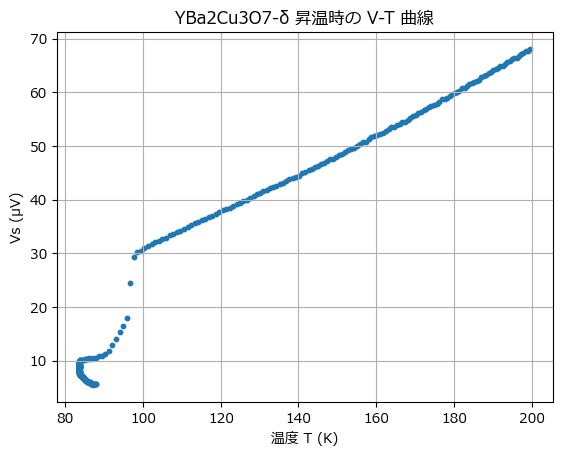

In [4]:
# V-T 曲線（昇温）
plt.figure()
plt.scatter(df_up["T_K"], df_up["Vs"],s=10)
plt.xlabel("温度 T (K)")
plt.ylabel("Vs (µV)")
plt.title("YBa2Cu3O7-δ 昇温時の V-T 曲線")
plt.grid(True)
plt.show()

## 3. 抵抗 $R$ の算出
オームの法則を用いて抵抗を算出する。

実験ノートにメモした10mAの電流値を用いる。


In [5]:

# 抵抗 R[Ω] の列を追加 
I_mA = 10 # mA
df_up["R_ohm"] = df_up["Vs"] / I_mA / 1000  # Ω に変換

df_up[["T_K","Vs","R_ohm"]].head()

,T_K,Vs,R_ohm
0,87.95,5.7,0.00057
1,87.85,5.7,0.00057
2,87.70,5.7,0.00057
3,87.65,5.6,0.00056
4,87.45,5.6,0.00056


## 4. 昇温時の R–T 曲線

ここから先は、CH1 ではなく 実抵抗 R を使って解析する。

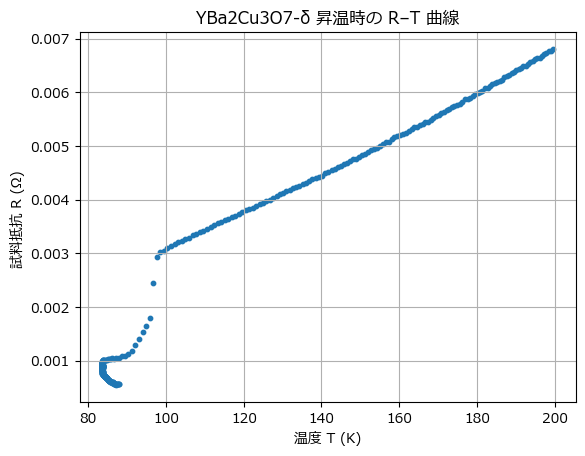

In [6]:

# R-T 曲線（昇温）
plt.figure()
plt.scatter(df_up["T_K"], df_up["R_ohm"],s=10)
plt.xlabel("温度 T (K)")
plt.ylabel("試料抵抗 R (Ω) ")
plt.title("YBa2Cu3O7-δ 昇温時の R–T 曲線")
plt.grid(True)
plt.show()


## 5. Tc(onset, mid, zero) の決定（昇温）

ここでは レポートに記した の定義にならって、常伝導状態と超伝導状態の代表値から
転移温度を 3 種類定義する。比例係数をかけても形は変わらないため、
CH1 でやっても R でやっても Tc の値は基本的に同じ になる。

In [7]:
# 常伝導状態の代表値 R_N: 130–150 K の平均
Rn_region = df_up[(df_up["T_K"]>130) & (df_up["T_K"]<150)]
R_N = Rn_region["R_ohm"].mean()

# 超伝導状態（低温側）の代表値 R_S: –90 K の平均
Rs_region = df_up[df_up["T_K"] < 90]
R_S = Rs_region["R_ohm"].mean()

# --- Tc_zero ---
# R が R_S の 30% 増しになった点を「抵抗がゼロから立ち上がる温度」とみなす
R_zero_thr = 1.3 * R_S
idx_zero = (df_up["R_ohm"] - R_zero_thr).abs().idxmin()
Tc_zero = df_up.loc[idx_zero, "T_K"]

# --- Tc_mid ---
# (R_N + R_S)/2 をとる温度
R_mid = 0.5 * (R_N + R_S)
idx_mid = (df_up["R_ohm"] - R_mid).abs().idxmin()
Tc_mid = df_up.loc[idx_mid, "T_K"]

# --- Tc_onset ---
# 高温側の直線と転移付近の急峻な直線の交点として決める
high = df_up[(df_up["T_K"]>130) & (df_up["T_K"]<200)]
m1, b1 = np.polyfit(high["T_K"], high["R_ohm"], 1)

steep = df_up[(df_up["T_K"]>92) & (df_up["T_K"]<100)]
m2, b2 = np.polyfit(steep["T_K"], steep["R_ohm"], 1)

Tc_onset = (b2 - b1) / (m1 - m2)

print(f"R_N ≈ {R_N:.3e} Ω  (常伝導)")
print(f"R_S ≈ {R_S:.3e} Ω  (超伝導)")
print(f"Tc_zero  ≈ {Tc_zero:.2f} K")
print(f"Tc_mid   ≈ {Tc_mid:.2f} K")
print(f"Tc_onset ≈ {Tc_onset:.2f} K")


R_N ≈ 4.464e-03 Ω  (常伝導)
R_S ≈ 8.278e-04 Ω  (超伝導)
Tc_zero  ≈ 88.70 K
Tc_mid   ≈ 96.75 K
Tc_onset ≈ 98.26 K


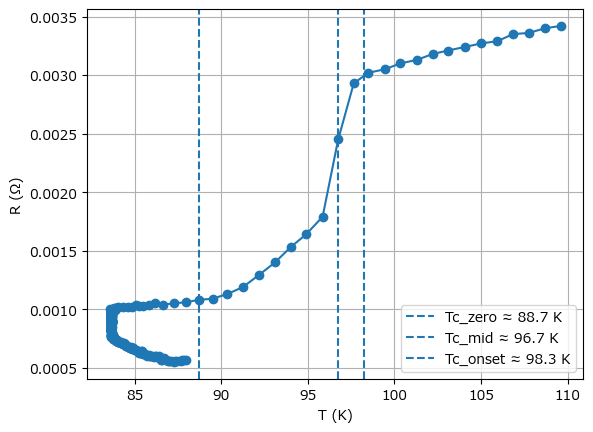

In [8]:

# 転移付近だけ拡大表示して確認
mask = (df_up["T_K"]>80) & (df_up["T_K"]<110)
plt.figure()
plt.plot(df_up.loc[mask, "T_K"], df_up.loc[mask, "R_ohm"], marker="o")
plt.axvline(Tc_zero,  linestyle="--", label=f"Tc_zero ≈ {Tc_zero:.1f} K")
plt.axvline(Tc_mid,   linestyle="--", label=f"Tc_mid ≈ {Tc_mid:.1f} K")
plt.axvline(Tc_onset, linestyle="--", label=f"Tc_onset ≈ {Tc_onset:.1f} K")
plt.xlabel("T (K)")
plt.ylabel("R (Ω)")
plt.legend()
plt.grid(True)
plt.show()


## 6. 降温データについて

- `超伝導_降温(完成版).xlsx` も列構成は同じなので、
  `df_up` を `df_down` に置き換えれば同じ手順で解析できる。
- 降温データでは **レンジが常時 100 µV** という条件であることに注意。

## 7. 降温データの読み込みと整形

In [9]:


up_path = "超伝導_降温(完成版).xlsx"
df_raw = pd.read_excel(up_path, sheet_name="超伝導_降温", header=None)

header_row = 14      # 「日付, 時刻, [ms], CH1, CH2, ...」の行
data_start_row = 17  # 実データが始まる行

colnames = [
    "date","time","ms","CH1_mV","Temp_C_max","Temp_C_min",
    "CH3_max","CH3_min","CH4_max","CH4_min","CH5_max","CH5_min","CH6_max","CH6_min"
]

df_down = df_raw.iloc[data_start_row:].reset_index(drop=True)
df_down.columns = colnames


for c in ["CH1_mV","Temp_C_max","Temp_C_min"]:
    df_down[c] = pd.to_numeric(df_down[c], errors="coerce")


df_down["T_K"] = (df_down["Temp_C_max"]+df_down["Temp_C_min"])/2 + 273.15

df_down.head()


,date,time,ms,CH1_mV,Temp_C_max,Temp_C_min,CH3_max,CH3_min,CH4_max,CH4_min,CH5_max,CH5_min,CH6_max,CH6_min,T_K
0,17/11/2025,14:38:00,0,5.18,17.7,17.7,50,50,50,50,50,50,50,50,290.85
1,17/11/2025,14:38:10,0,5.18,17.7,17.7,50,50,50,50,50,50,50.01,50,290.85
2,17/11/2025,14:38:20,0,5.18,17.7,17.4,50,50,50,50,50,49.99,50,50,290.70
3,17/11/2025,14:38:30,0,5.16,17.5,17.2,50,49.99,50,50,50,49.99,50,50,290.50
4,17/11/2025,14:38:40,0,5.17,17.5,17.2,50,49.99,50,50,50,49.99,50,50,290.50


## 8. レコーダ電圧 $V_R$ → 実電圧 $V_s$ への変換


レンジが50μVであることを用いて実電圧に換算する。


In [10]:
df_down["Vs"] = df_down["CH1_mV"]*100*0.1

df_down[["CH1_mV","Vs"]].head()

,CH1_mV,Vs
0,5.18,51.8
1,5.18,51.8
2,5.18,51.8
3,5.16,51.6
4,5.17,51.7


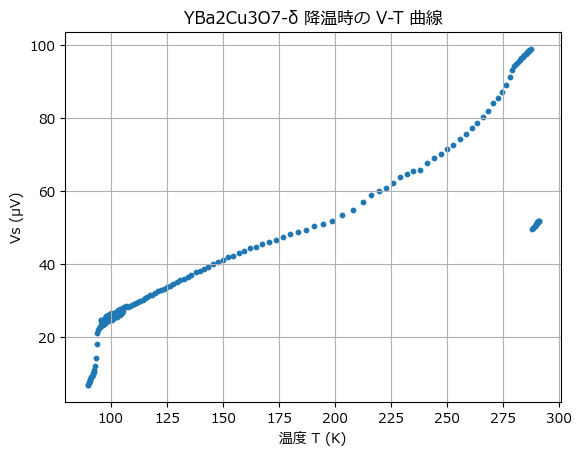

In [11]:
# V-T 曲線（降温）
plt.figure()
plt.scatter(df_down["T_K"], df_down["Vs"], s=10)
plt.xlabel("温度 T (K)")
plt.ylabel("Vs (µV)")
plt.title("YBa2Cu3O7-δ 降温時の V-T 曲線")
plt.grid(True)
plt.show()

ここで、**飛び値**があることが分かったので、これを除く。

ジャンプっぽいところ: 14 T_K    287.4
Vs      99.0
Name: 14, dtype: object


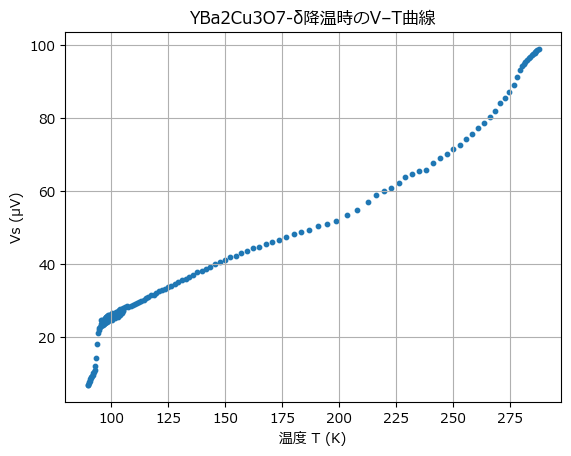

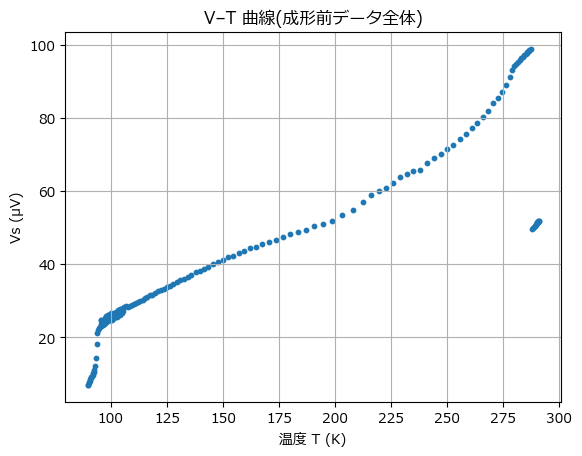

In [12]:
# CH1_mV でも R_ohm でも好きなほうでOK
dV = df_down["Vs"].diff().abs()

# いちばん大きく飛んでいる場所の index
idx_jump = dV.idxmax()
print("ジャンプっぽいところ:", idx_jump, df_down.loc[idx_jump, ["T_K","Vs"]])

# そのジャンプ以降だけを使う
df_down_use = df_down.iloc[idx_jump:].reset_index(drop=True)

plt.figure()
plt.scatter(df_down_use["T_K"], df_down_use["Vs"],s=10)
plt.xlabel("温度 T (K)")
plt.ylabel("Vs (µV)")
plt.title("YBa2Cu3O7-δ降温時のV–T曲線")
plt.grid(True)
plt.show()

# R-T 曲線（降温）
plt.figure()
plt.scatter(df_down["T_K"], df_down["Vs"],s=10)
plt.xlabel("温度 T (K)")
plt.ylabel("Vs (µV)")
plt.title("V–T 曲線(成形前データ全体)")
plt.grid(True)
plt.show()


## 9. 抵抗 $R$ の算出
オームの法則を用いて抵抗を算出する。

実験ノートにメモした10mAの電流値を用いる。


In [13]:

# 抵抗 R[Ω] の列を追加 
I_mA = 10 # mA
df_down_use["R_ohm"] = df_down_use["Vs"] / I_mA / 1000  # Ω に変換

df_down_use[["T_K","Vs","R_ohm"]].head()

,T_K,Vs,R_ohm
0,287.40,99.0,0.00990
1,286.65,98.8,0.00988
2,286.35,98.5,0.00985
3,285.80,98.1,0.00981
4,285.60,97.8,0.00978


## 10. 降温時の R–T 曲線

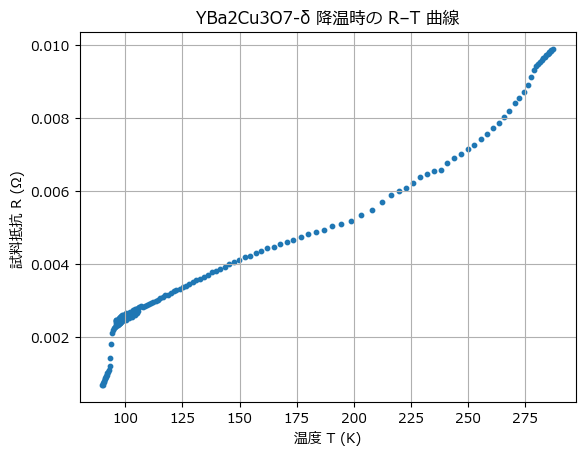

In [14]:

# R-T 曲線（降温）
plt.figure()
plt.scatter(df_down_use["T_K"], df_down_use["R_ohm"],s=10)
plt.xlabel("温度 T (K)")
plt.ylabel("試料抵抗 R (Ω) ")
plt.title("YBa2Cu3O7-δ 降温時の R–T 曲線")
plt.grid(True)
plt.show()


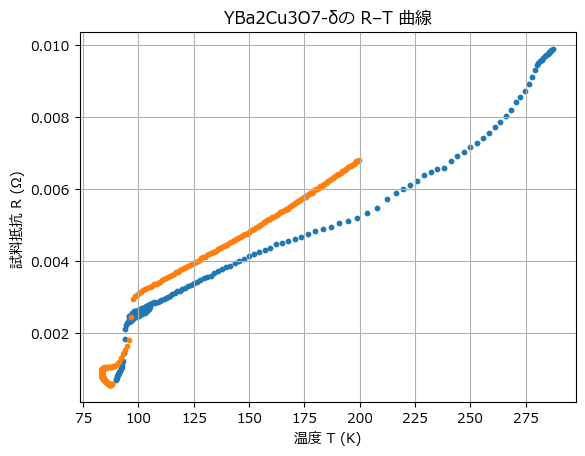

In [ ]:

plt.figure()
plt.scatter(df_down_use["T_K"], df_down_use["R_ohm"],s=10)
plt.scatter(df_up["T_K"], df_up["R_ohm"],s=10)
plt.xlabel("温度 T (K)")
plt.ylabel("試料抵抗 R (Ω) ")
plt.title("YBa2Cu3O7-δの R–T 曲線")
plt.grid(True)
plt.show()

In [16]:
# 常伝導状態の代表値 R_N: 130–150 K の平均
Rn_region = df_down_use[(df_down_use["T_K"]>130) & (df_down_use["T_K"]<150)]
R_N = Rn_region["R_ohm"].mean()

# 超伝導状態（低温側）の代表値 R_S: -90 K の平均
Rs_region = df_down_use[df_down_use["T_K"] < 90]
R_S = Rs_region["R_ohm"].mean()

# --- Tc_zero ---
# R が R_S の 30% 増しになった点を「抵抗がゼロから立ち上がる温度」とみなす
R_zero_thr = 1.3 * R_S
idx_zero = (df_down_use["R_ohm"] - R_zero_thr).abs().idxmin()
Tc_zero = df_down_use.loc[idx_zero, "T_K"]

# --- Tc_mid ---
# (R_N + R_S)/2 を とる温度
R_mid = 0.5 * (R_N + R_S)
idx_mid = (df_down_use["R_ohm"] - R_mid).abs().idxmin()
Tc_mid = df_down_use.loc[idx_mid, "T_K"]

# --- Tc_onset ---
# 高温側の直線と転移付近の急峻な直線の交点として決める
high = df_down_use[(df_down_use["T_K"]>130) & (df_down_use["T_K"]<200)]
m1, b1 = np.polyfit(high["T_K"], high["R_ohm"], 1)

steep = df_down_use[(df_down_use["T_K"]>92) & (df_down_use["T_K"]<100)]
m2, b2 = np.polyfit(steep["T_K"], steep["R_ohm"], 1)

Tc_onset = (b2 - b1) / (m1 - m2)

print(f"R_N ≈ {R_N:.3e} Ω  (常伝導)")
print(f"R_S ≈ {R_S:.3e} Ω  (超伝導)")
print(f"Tc_zero  ≈ {Tc_zero:.2f} K")
print(f"Tc_mid   ≈ {Tc_mid:.2f} K")
print(f"Tc_onset ≈ {Tc_onset:.2f} K")


R_N ≈ 3.830e-03 Ω  (常伝導)
R_S ≈ 7.050e-04 Ω  (超伝導)
Tc_zero  ≈ 91.35 K
Tc_mid   ≈ 94.90 K
Tc_onset ≈ 99.74 K


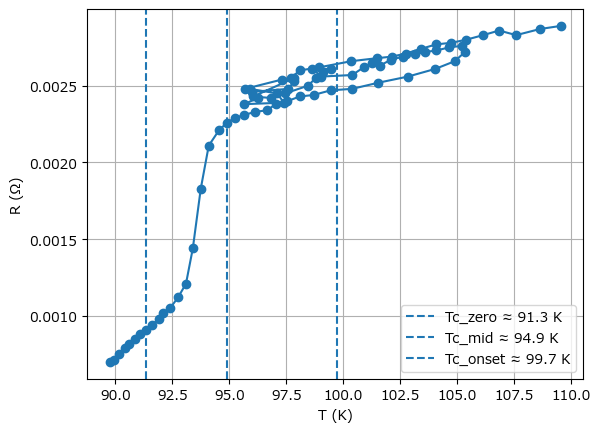

In [17]:

# 転移付近だけ拡大表示して確認
mask = (df_down_use["T_K"]>80) & (df_down_use["T_K"]<110)
plt.figure()
plt.plot(df_down_use.loc[mask, "T_K"], df_down_use.loc[mask, "R_ohm"], marker="o")
plt.axvline(Tc_zero,  linestyle="--", label=f"Tc_zero ≈ {Tc_zero:.1f} K")
plt.axvline(Tc_mid,   linestyle="--", label=f"Tc_mid ≈ {Tc_mid:.1f} K")
plt.axvline(Tc_onset, linestyle="--", label=f"Tc_onset ≈ {Tc_onset:.1f} K")
plt.xlabel("T (K)")
plt.ylabel("R (Ω)")
plt.legend()
plt.grid(True)
plt.show()